## 2(3) Weather
위 데이터는 기상청 종관기상관측(ASOS) 데이터로 제주도 내 제주, 고산, 성산, 서귀포 관측소에서 측정한 데이터이다.<br>
기상청의 관측지침을 참고하여 센서를 통해, 관측자의 주관 개입 없이 측정되는 항목만을 외부데이터로 사용한다.
- train data는 해당 기간의 데이터로 병합한다.
- test data는 2022.08. 시점 이후 데이터를 사용하는 것이 Data leakage임에 2019.8.~2022.7. 데이터로 ARIMA를 학습시켜 예측한다.

In [ ]:
# https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0
# https://ahnjg.tistory.com/33

In [4]:
train_index = pd.date_range('20190801 00:00','20220731 23:00',freq='H')

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
plt.rcParams['font.family'] = 'Malgun Gothic'
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
train = pd.read_parquet('../data/clean/clean_train.parquet')
test = pd.read_parquet('../data/clean/clean_test.parquet')

label = {0:'고산',1:'성산',2:'서귀포',3:'제주'}
train['start_cluster'] = train['start_cluster'].map(label)
train['end_cluster'] = train['end_cluster'].map(label)

In [3]:
# 기상데이터
kma_19 = pd.read_csv('../data/out_data/OBS_ASOS_TIM_20221019193132.csv', parse_dates=['일시'], encoding='cp949')
kma_20 = pd.read_csv('../data/out_data/OBS_ASOS_TIM_20221019193315.csv', parse_dates=['일시'], encoding='cp949')
kma_21 = pd.read_csv('../data/out_data/OBS_ASOS_TIM_20221019193552.csv', parse_dates=['일시'], encoding='cp949')
kma = pd.concat([kma_19, kma_20, kma_21])

# 불필요한 열 삭제
del kma['지점']

# 컬럼명의 특수기호 삭제
kma.columns = kma.columns.map(lambda x: x if x.find('(') == -1 else x[:x.find('(')])

# 추후 결합을 위해 kma_21에 column을 생성한다.
kma['base_date'] = (kma.일시.dt.year.astype(str)\
                    +kma.일시.dt.month.astype(str).str.zfill(2)\
                    +kma.일시.dt.day.astype(str).str.zfill(2)).astype(int)
kma['base_hour'] = kma.일시.dt.hour

<AxesSubplot:>

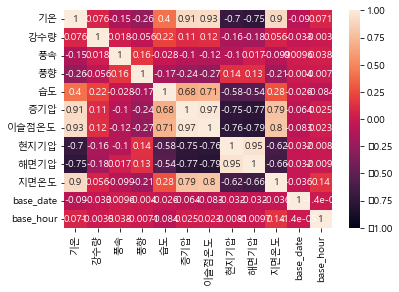

In [5]:
sns.heatmap(kma.corr(), annot=True, vmax=1, vmin=-1)

### Data Cleansing
기간 내 결측인 데이터를 처리한다.

In [5]:
# 강수량의 결측치를 0으로 채운다.
kma['강수량'].fillna(0, inplace=True)

In [6]:
# 각 지점으로 데이터 분리
date = pd.date_range('20190801 00:00','20220731 23:00',freq='H') ; print('데이터수:', date.shape[0])
jeju = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="제주"'), on='일시', how='left')
gosan = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="고산"'), on='일시', how='left')
sungsan = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="성산"'), on='일시', how='left')
seogwipo = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="서귀포"'), on='일시', how='left')

데이터수: 26304


In [7]:
# 고산, 성산, 서귀포 데이터에는 모든 값이 결측인 날들이 존재한다.
print('제주 관측소 결측데이터')
display(jeju.isna().sum()/jeju.shape[0])
print('고산 관측소 결측데이터')
display(gosan.isna().sum()/gosan.shape[0])
print('성산 관측소 결측데이터')
display(sungsan.isna().sum()/sungsan.shape[0])
print('서귀포 관측소 결측데이터')
display(seogwipo.isna().sum()/seogwipo.shape[0])

제주 관측소 결측데이터


일시           0.000000
지점명          0.000000
기온           0.000190
강수량          0.000000
풍속           0.000304
풍향           0.000304
습도           0.000000
증기압          0.000076
이슬점온도        0.000190
현지기압         0.000038
해면기압         0.000076
지면온도         0.000114
base_date    0.000000
base_hour    0.000000
dtype: float64

고산 관측소 결측데이터


일시           0.000000
지점명          0.000342
기온           0.000646
강수량          0.000342
풍속           0.001673
풍향           0.002585
습도           0.000342
증기압          0.000456
이슬점온도        0.000532
현지기압         0.001293
해면기압         0.001293
지면온도         0.000532
base_date    0.000342
base_hour    0.000342
dtype: float64

성산 관측소 결측데이터


일시           0.000000
지점명          0.000076
기온           0.000114
강수량          0.000076
풍속           0.008592
풍향           0.008858
습도           0.000076
증기압          0.000190
이슬점온도        0.000228
현지기압         0.000266
해면기압         0.000190
지면온도         0.000076
base_date    0.000076
base_hour    0.000076
dtype: float64

서귀포 관측소 결측데이터


일시           0.000000
지점명          0.000038
기온           0.000152
강수량          0.000038
풍속           0.000038
풍향           0.000038
습도           0.000038
증기압          0.000152
이슬점온도        0.000266
현지기압         0.000076
해면기압         0.000076
지면온도         0.000076
base_date    0.000038
base_hour    0.000038
dtype: float64

In [ ]:
# 22.3.24. 4시 -> 22.3.23. 4시, 22.3.22. 4시, 22.3.21. 4시 

In [8]:
# 최근 3일의 동시간 데이터 평균으로 결측치를 채운다.
def mean_threeday(DATA):
    for COL in range(DATA.shape[1]):
        if DATA.iloc[:,COL].isna().sum() > 0:
            for INDEX in DATA[DATA.iloc[:,COL].isna()].index.values:
                DATA.iloc[INDEX, COL] = kma.iloc[[INDEX-72,INDEX-48,INDEX-24], COL].mean()
    return DATA

In [9]:
clean_jeju = mean_threeday(jeju)
clean_gosan = mean_threeday(gosan)
clean_sungsan = mean_threeday(sungsan)
clean_seogwipo = mean_threeday(seogwipo)

In [10]:
clean_kma = pd.concat([clean_jeju, clean_gosan, clean_sungsan, clean_seogwipo])
clean_kma.to_csv('../data/out_data/clean_kma.csv', index=False)

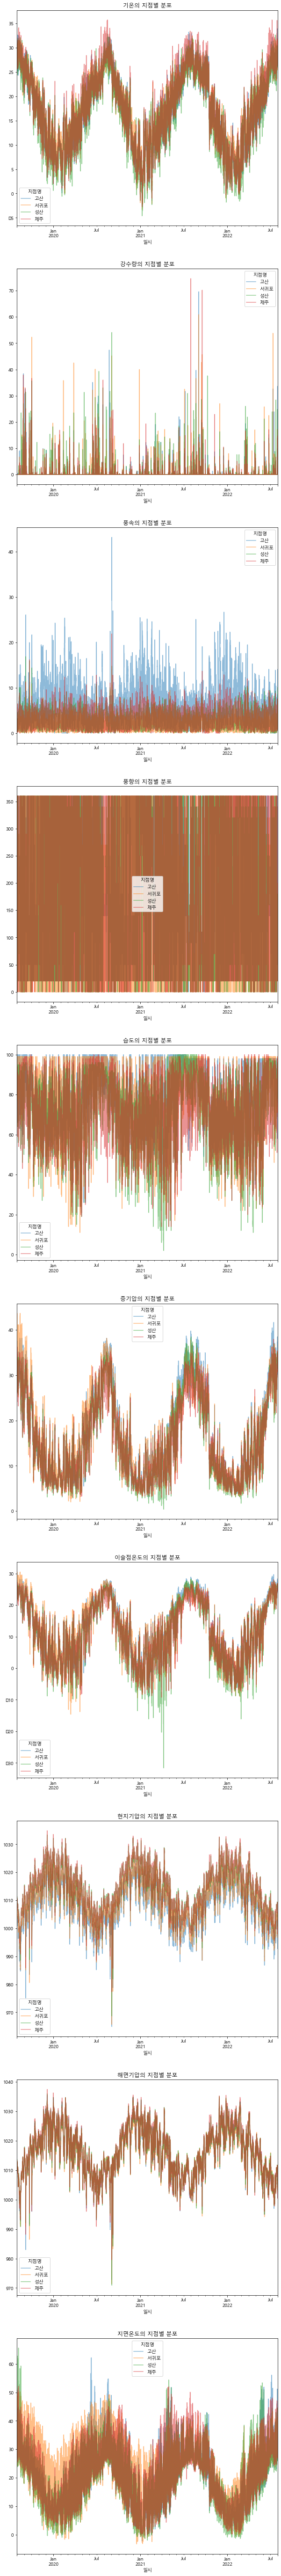

In [17]:
# 시각화로 확인해본다.
fig, ax = plt.subplots(10,1, figsize=(10,100))
for i in clean_kma.columns[2:12]:
    pd.pivot_table(kma, index='일시', columns='지점명', values=i, aggfunc=np.mean)\
    .plot(title=f"{i}의 지점별 분포", alpha=0.5, ax=ax[clean_kma.columns.get_loc(i)-2])
plt.show()

### Train Data

In [14]:
# 데이터와 가까운 관측소의 기상데이터를 반영하기 위해 Clustering을 시도한다.
cluster = KMeans(n_clusters=4, random_state=2022).fit(np.vstack((train[['start_latitude','start_longitude']].values, 
                                                                 train[['end_latitude','end_longitude']].values)))
train['start_cluster'] = cluster.predict(train[['start_latitude','start_longitude']].values)
train['end_cluster'] = cluster.predict(train[['end_latitude','end_longitude']].values)

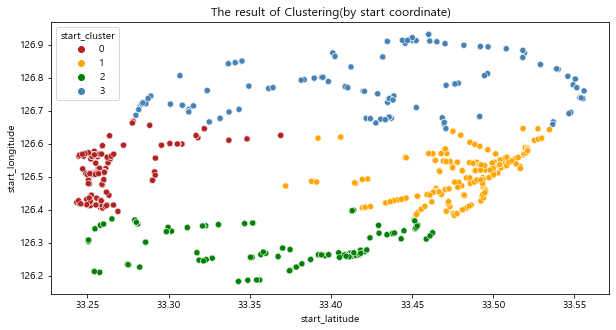

In [15]:
# 각 클러스터가 어느 기상관측지점과 가까울 지 보기 위해 출발위경도만 scatterplot을 그려본다.
# 0번은 '고산', 1번은 '성산', 2번은 '서귀포', 3번은 '제주'로 봐도 무방함을 확인하였다.
plt.figure(figsize=(10,5))
sns.scatterplot(data=train[['start_latitude','start_longitude','start_cluster']], 
                x='start_latitude',y='start_longitude',hue='start_cluster',
                palette=['firebrick','orange','green','steelblue'])
plt.title("The result of Clustering(by start coordinate)")
plt.show()

In [16]:
label = {0:'고산',1:'성산',2:'서귀포',3:'제주'}
train['start_cluster_str'] = train['start_cluster'].map(label)
train['end_cluster_str'] = train['end_cluster'].map(label)

In [20]:
# start_cluster와 end_cluster가 동일한 데이터와 상이한 데이터 모두 존재함에 
# start_cluster, end_cluster에 해당하는 관측정보를 모두 결합 후 평균으로 데이터를 생성한다.
print('병합 전 train.shape:', train.shape)

ease = pd.concat([pd.merge(train[['id','base_date','base_hour','start_cluster_str']], clean_kma, 
                           left_on=['base_date','base_hour','start_cluster_str'],right_on=['base_date','base_hour','지점명']),
                  pd.merge(train[['id','base_date','base_hour','end_cluster_str']], clean_kma, 
                           left_on=['base_date','base_hour','end_cluster_str'], right_on=['base_date','base_hour','지점명'])])
weather_train = ease.groupby('id')[ease.columns[4:15]].mean().reset_index()
weather_train = pd.merge(weather_train, train[['id','start_cluster','end_cluster']], on='id')
print('병합 후 train.shape:', weather_train.shape)

병합 전 train.shape: (4701217, 48)
병합 후 train.shape: (4700214, 12)


In [22]:
weather_train.to_parquet('../data/clean/weather_train.parquet')

### Predict Test Data

In [19]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [20]:
# Get diff number
def test_nonstationary(DATA):
    print('ADF Statistic p-value:', adfuller(DATA)[1])
    return (adfuller(DATA)[1] >= 0.05)

def get_diff(DATA):
    for i in range(1,5):
        result = adfuller(DATA.diff(i)[i:])
        if result[1] < 0.05:
            print('ADF Statistic p-value:', result[1])
            return i

In [40]:
def get_diff(DATA):
    for i in range(1,5):
        result = adfuller(DATA.diff(i)[i:])
        if result[1] < 0.05:
            return i, result[1]

In [42]:
print(get_diff(clean_jeju.iloc[:,3]))

(1, 0.0)


In [43]:
data_list = [clean_jeju]

diff = []
for DATA in data_list:
    for COL in range(2,12):
        print(get_diff(DATA.iloc[:,COL]))

(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)


In [44]:
data_list = [clean_gosan]

diff = []
for DATA in data_list:
    for COL in range(2,12):
        print(get_diff(DATA.iloc[:,COL]))

(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)


In [45]:
data_list = [clean_sungsan]

diff = []
for DATA in data_list:
    for COL in range(2,12):
        print(get_diff(DATA.iloc[:,COL]))

(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)


In [47]:
data_list = [clean_seogwipo]

diff = []
for DATA in data_list:
    for COL in range(2,12):
        print(get_diff(DATA.iloc[:,COL]))

(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)


In [27]:
data_list = [clean_jeju, clean_gosan, clean_sungsan, clean_seogwipo]

diff = []
for DATA in data_list:
    ease_diff = []
    for COL in range(2,12):
        ease_diff.append(get_diff(DATA.iloc[:,COL], test_nonstationary(DATA.iloc[:,COL])))
        diff.append(ease_diff)

ADF Statistic p-value: 0.00011429832139756523
ADF Statistic p-value: 0.0
ADF Statistic p-value: 6.367412079808365e-30
ADF Statistic p-value: 0.0
ADF Statistic p-value: 4.274596102940018e-24
ADF Statistic p-value: 0.00025839135682612254
ADF Statistic p-value: 6.037879526913164e-06
ADF Statistic p-value: 2.7699236527615083e-11
ADF Statistic p-value: 2.270464309168259e-11
ADF Statistic p-value: 0.002459166068353312
ADF Statistic p-value: 0.00011383407182319363
ADF Statistic p-value: 0.0
ADF Statistic p-value: 1.093061942875837e-29
ADF Statistic p-value: 4.763677249249561e-28
ADF Statistic p-value: 2.215608074079198e-19
ADF Statistic p-value: 0.0008117146455598152
ADF Statistic p-value: 2.053567279361054e-05
ADF Statistic p-value: 9.457343052027521e-12
ADF Statistic p-value: 1.9298138212424752e-11
ADF Statistic p-value: 0.0005235883376923147
ADF Statistic p-value: 5.3082843069356966e-05
ADF Statistic p-value: 0.0
ADF Statistic p-value: 1.0640601356325086e-29
ADF Statistic p-value: 2.136463

In [27]:
data_list = [clean_jeju, clean_gosan, clean_sungsan, clean_seogwipo]

diff = []
for DATA in data_list:
    ease_diff = []
    for COL in range(2,12):
        ease_diff.append(get_diff(DATA.iloc[:,COL], test_nonstationary(DATA.iloc[:,COL])))
        diff.append(ease_diff)

ADF Statistic p-value: 0.00011429832139756523
ADF Statistic p-value: 0.0
ADF Statistic p-value: 6.367412079808365e-30
ADF Statistic p-value: 0.0
ADF Statistic p-value: 4.274596102940018e-24
ADF Statistic p-value: 0.00025839135682612254
ADF Statistic p-value: 6.037879526913164e-06
ADF Statistic p-value: 2.7699236527615083e-11
ADF Statistic p-value: 2.270464309168259e-11
ADF Statistic p-value: 0.002459166068353312
ADF Statistic p-value: 0.00011383407182319363
ADF Statistic p-value: 0.0
ADF Statistic p-value: 1.093061942875837e-29
ADF Statistic p-value: 4.763677249249561e-28
ADF Statistic p-value: 2.215608074079198e-19
ADF Statistic p-value: 0.0008117146455598152
ADF Statistic p-value: 2.053567279361054e-05
ADF Statistic p-value: 9.457343052027521e-12
ADF Statistic p-value: 1.9298138212424752e-11
ADF Statistic p-value: 0.0005235883376923147
ADF Statistic p-value: 5.3082843069356966e-05
ADF Statistic p-value: 0.0
ADF Statistic p-value: 1.0640601356325086e-29
ADF Statistic p-value: 2.136463

In [28]:
diff

[[False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, 

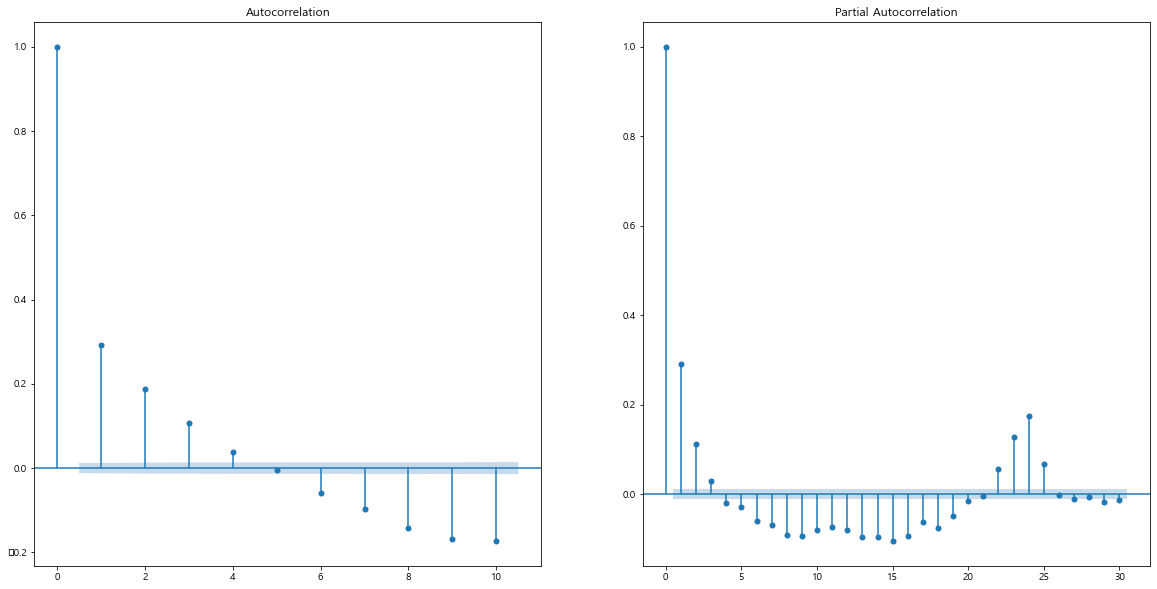

In [49]:
# Get p, q number
fig, ax = plt.subplots(1,2,figsize=(20,10))
sm.graphics.tsa.plot_acf(clean_jeju.iloc[:,2].diff(1)[1:], lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(clean_jeju.iloc[:,2].diff(1)[1:], lags=30, ax=ax[1])
plt.show()

In [50]:
model = ARIMA(clean_jeju.iloc[:,2], order=(20,1,3))
model_fit = model.fit(disp=0)

KeyboardInterrupt: 

In [ ]:
test_ex = pd.DataFrame({'date', pd.date_range('20190801 00:00','20220731 23:00',freq='H')})
test_ex

In [ ]:
import datetime

In [ ]:
predict = model_fit.predict(start=datetime(2022,8,1), end=datetime(2022,8,31),typ='levels')

In [ ]:
predict.plot()

### Save Data

In [25]:
train_clean.to_parquet('../data/raw/train_weather.parquet')